# Rich Document Vectors

The vectorizers library allows for rich document embeddings that combine the benefits of word vectors and bag-of-words style document representations. This tutorial will step you through the process of building these kinds of document representations. One caveat to note is that this approach is only going to be reasonably effective if you have enough training text to learn reasonable word vectors. If you have limited text, or your documents are all very short (and thus don't provide enough context to learn word vectors), this approach may have limited success. You can, however, always use word vectors trained on a larger corpus and substitute them in.

We will start by loading the libraries we will need.

In [1]:
import numpy as np
import pandas as pd
import sklearn.datasets
import sentencepiece
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import io
import datetime
import humanize
      
warnings.simplefilter("ignore")
sns.set()

As an example dataset we will use the 20-newsgroups data. It is both readily available via scikit-learn, small enough for easy use in a tutorial, but still large enough to be able to build good word vectors and document representations. Furthermore the 20-newsgroup dataset has a lot of somewhat idiomatic language, with word usage differing from common usage in a variety of ways -- this means that learning word vectors directly from the text, rather than using a pretrained model, will be particularly beneficial.

In [2]:
dataset = sklearn.datasets.fetch_20newsgroups(
    subset="all", remove=("headers", "footers", "quotes")
)

The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

Here are the categories:

 * `alt.atheism`,
 * `comp.graphics`,
 * `comp.os.ms-windows.misc`,
 * `comp.sys.ibm.pc.hardware`,
 * `comp.sys.mac.hardware`,
 * `comp.windows.x`,
 * `misc.forsale`,
 * `rec.autos`,
 * `rec.motorcycles`,
 * `rec.sport.baseball`,
 * `rec.sport.hockey`,
 * `sci.crypt`,
 * `sci.electronics`,
 * `sci.med`,
 * `sci.space`,
 * `soc.religion.christian`,
 * `talk.politics.guns`,
 * `talk.politics.mideast`,
 * `talk.politics.misc`,
 * `talk.religion.misc`

The current version is obtained by wrapping `sklearn.datasets.fetch_20newsgroups`, which comes from this [20 newsgroups webpage](http://qwone.com/~jason/20Newsgroups/).

By default we follow the sklearn suggestion to set `remove=('headers', 'footers', 'quotes')` to avoid overfitting.

Since there are a number of posts that are extremely short, and provide very little information we will prune those out to make the whole process run a little smoother. We have chosen a (somewhat arbitrary) limit requiring that posts have at least 280 characters (longer than a tweet).

In [3]:
long_enough = [len(t) > 280 for t in dataset["data"]]
targets = np.array(dataset.target)[long_enough]
news_data = [t.lower() for t in dataset["data"] if len(t) > 280]

Lastly, to aid in visualization we will construct a custom colormap that groups the various newsgroups into higher level clusters (religion, politics, computing, science, sports, and misc).

In [4]:
religion = ("alt.atheism", "talk.religion.misc", "soc.religion.christian")
politics = ("talk.politics.misc", "talk.politics.mideast", "talk.politics.guns")
sport = ("rec.sport.baseball", "rec.sport.hockey")
comp = (
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
)
sci = (
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
)
misc = (
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
)

COLOR_KEY = {}
COLOR_KEY.update(zip(religion, sns.color_palette("Blues", 4).as_hex()[1:]))
COLOR_KEY.update(zip(politics, sns.color_palette("Purples", 4).as_hex()[1:]))
COLOR_KEY.update(zip(comp, sns.color_palette("YlOrRd", 5).as_hex()))
COLOR_KEY.update(zip(sci, sns.color_palette("light:teal", 5).as_hex()[1:]))
COLOR_KEY.update(zip(sport, sns.color_palette("light:#660033", 4).as_hex()[1:3]))
COLOR_KEY.update(zip(misc, sns.color_palette("YlGn", 4).as_hex()[1:]))

## Step 0: Tokenization

The vectorizers library is designed to be general purpose, and thus it is based around the more generic case of sequences of tokens rather than text. Thus in order to get our text into the vectorizers library we first must convert it into sequences of tokens. This is a common task in natural language processing and is handled by a tokenizer, of which there are many. Tokenization can be as simple as breaking on spaces and puncutation (for languages like English), but can also be much more complicated. Tokenizers are available in [NLTK](https://www.nltk.org/api/nltk.tokenize.html), [SpaCy](https://spacy.io/api/tokenizer), the [tokenizers library from Huggingface](https://github.com/huggingface/tokenizers), but for 20-newsgroups we'll use [SentencePiece](https://github.com/google/sentencepiece). Feel free to substitute in your preferred tokenizer.

The first step is to train sentencepiece on the data; while we don't have a lot of training data the data itself is rather idiomatic and unique, so learning to parse and tokenize it rather than using a pretrained tokenization is worthwhile.

In [5]:
%%time
model_buffer = io.BytesIO()
sentencepiece.SentencePieceTrainer.Train(
    sentence_iterator=(x for x in news_data), model_writer=model_buffer, vocab_size=10000
)
sp_parser = sentencepiece.SentencePieceProcessor(model_proto=model_buffer.getvalue())

CPU times: user 1min 14s, sys: 8.48 s, total: 1min 23s
Wall time: 40.7 s


With that done it is a simple matter to generate tokenized versions of each of the newgroup posts. This does not actually take very long.

In [6]:
%%time
tokenized_news = sp_parser.encode(news_data, out_type="str")

CPU times: user 14.8 s, sys: 6.59 s, total: 21.4 s
Wall time: 21.5 s


Since we are going to be looking at and comparing the different amounts of time taken by the different vectorization approaches available in the vectorizers library, we'll actually go a step further and use the %timeit notebook magic to save off the amount of time tokenization takes.

In [7]:
tokenization_time = %timeit -n 1 -r 1 -o sp_parser.encode(news_data, out_type="str")

28.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Step 1: Generate Word Vectors

The next major step is the generation of word vectors -- this is what will allow us to generate muhc richer document representations than standard approaches that rely purely on a bag-of-words model. Since the 20-newsgroup data has relatively different and idiomatic language usage we will gain quite a bit by training word vectors on the actual data itself rather than relying on more generic pre-trained word vectors. This can be handled by the ``TokenCooccurrenceVectorizer`` which does fancy versions of counting how often two tokens occur near each other in a list of token sequences. See the Word Embedding tutorial for more information on creating work vectors with the vectorizers library.

In [8]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=(1, 20),
    window_functions=("fixed", "variable"),
    kernel_functions=("geometric", "geometric"),
    kernel_args=({}, {"offset":1}),
    mask_string="[##MASK##]",
    nullify_mask=True,
    n_iter=2,
    normalize_windows=True,
    n_threads=4,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=150)

CPU times: user 19min 23s, sys: 1min 50s, total: 21min 14s
Wall time: 7min 37s


As noted, we will keep track of how long things take. In practice since we are using the numba library for JIT compilation the second run, with everything already JIT compiled, can be faster.

In [9]:
word_vector_time = %timeit -n 1 -r 1 -o word_vectorizer.fit(tokenized_news).reduce_dimension(dimension=150, algorithm="randomized")

7min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Step 2: Generate Simple Document Vectors Using the Learned Vocabulary

To build rich document vectors we start with simple ones. The basis for that is the same as the basis for most other simple document vectors: a bag-of-words model that simply counts how often each word in the vocabulary appears in each of the documents. In this case, since we have a pre-specified vocabulary of word vectors which we just built, we will constrain out vocabulary to those words. To actually build the matrix of counts we will use the ``NgramVectorizer`` which has a default n-gram size of 1 -- in other words it will simply count tokens. We could do more advanced things, such as using longer n-grams and averaging word vectors for each n-gram, etc. but for now we will keep things very simple.

In [10]:
%%time
ngrammer = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
)
doc_matrix = ngrammer.fit_transform(tokenized_news)

CPU times: user 45.9 s, sys: 899 ms, total: 46.8 s
Wall time: 46.9 s


As before we will record how long this actually took for later reference.

In [11]:
doc_matrix_time = %timeit -n 1 -r 1 -o ngrammer.fit_transform(tokenized_news)

42.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The next step is an alternative approach to the popular "inverse-document-frequence" or "IDF" weighting. Instead of IDF weighting the columns we will use the ``InformationWeightTransformer`` to weight the columns by the relative information gain over expectation of each of the columns. That is, we will weight each word (since each column corresponds to a different word in the vocabulary) by how much the distribution of the word's occurrences deviates from what we would expect based solely on document length. This can be a surprisingly powerful approach (as we will see later).

In [12]:
%%time
info_weighter = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_doc_matrix = info_weighter.fit_transform(doc_matrix)

CPU times: user 3.18 s, sys: 60.8 ms, total: 3.25 s
Wall time: 3.27 s


And as always we will keep track of how long this operation takes. Again, due to numba and compilation, this takes less time once we have the functions already JIT compiled.

In [13]:
info_matrix_time = %timeit -n 1 -r 1 -o info_weighter.fit_transform(doc_matrix)

1.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Step 3a: Combine Word and Document Vectors with WassersteinVectorizer

Now we need a way to combine that basic bag-of-words representation of documents with the word vector information we previously constructed. This is what will allow us to see two documents as similar if they use, say, synonymous words, rather than matching exactly on word choices. To do this we will view our bag-of-words as a bag-of-word-vectors. We can turn a bag-of-vectors, or "point cloud" into a single vector by means of Linear Optimal Transport (LOT). The core idea is that one can compare two distributions using Wasserstein distance by looking at how much "work" it would take to "transport" the mass of one distribution to the other under and optimal transport plan. For comparing bags-of-word-vectors this amounts to what is sometimes referred to as word-mover-distance. With LOT we attempt to embed the space of distributions under such a distance metric into a linear space. In the vectorizers library this theory has been packaged up into the ``WassersteinVectorizer`` uses LOT based techniques to provide vector representations of bags-of-vectors such that the distance between vectors correlates with the Wasserstein distance between bags-of-vectors.

After instantiating a model can fit it to data by provding the fit method with the bag information in the form of a sparse matrix, exactly as provided to us by ``NgramVectorizer`` and ``InformationWeightTransformer``, and the vectors associated to each of the columns of that matrix. In our case, since the columns of the ``info_doc_matrix`` are already in the same order as the word vectors because we explicitly used the ``word_vectorizer``'s vocabulary, we can simply pass in the word vectors. The result is a set of vectors such that each vector captures information about the distribution of word vectors that make up the document.

In [14]:
%%time
we_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    memory_size="4G",
    random_state=42,
)
we_vectors = we_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

CPU times: user 9min 21s, sys: 1min 11s, total: 10min 32s
Wall time: 3min 15s


As always we will ensure that we record the amount of time this step takes. In this case it is worth noting that, even after having numba JIT compile the functions, this still takes quite some time even for the relatively small corpus we have here.

In [15]:
wasserstein_time = %timeit -n 1 -r 1 -o we_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

4min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


To see if this is working we can visualize the results using UMAP. If we colour each document (newsgroup post) byt he newsgroup is came from we can see that the ``WassersteinVectorizer`` has produced vectors that do a remarkably good job at separating out the different newsgroups.

<AxesSubplot:>

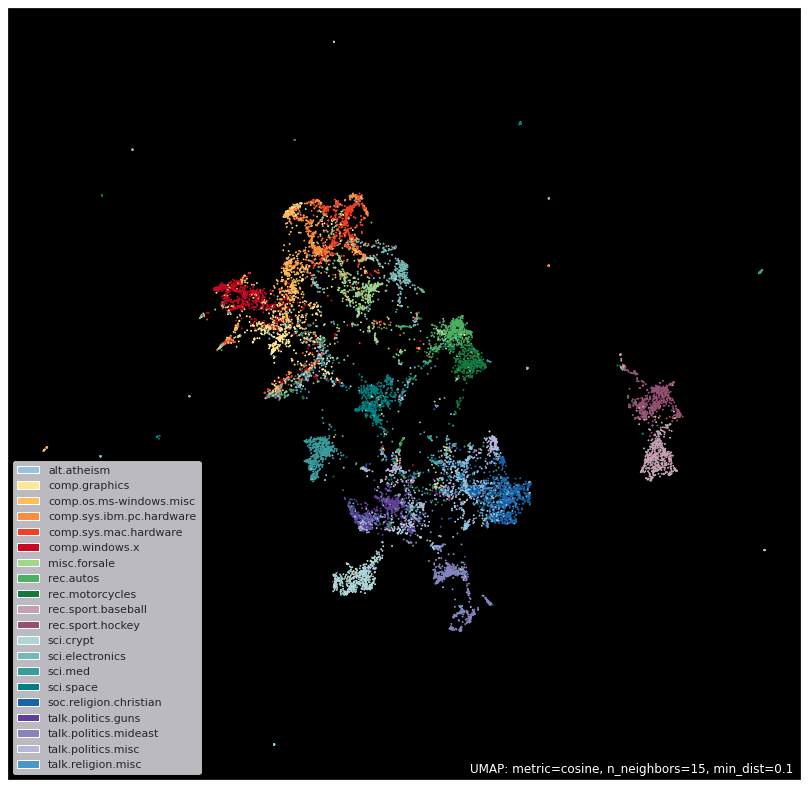

In [16]:
we_mapper = umap.UMAP(metric="cosine", random_state=42).fit(we_vectors)
umap.plot.points(
    we_mapper,
    labels=np.array([dataset['target_names'][x] for x in targets]),
    color_key=COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
)

## Step 3b: Combine Word and Document Vectors with SinkhornVectorizer

Solving optimal transport problems is computationally expensive. The ``WassersteinVectorizer`` does a good job by doing a one time set of optimal transport computations to vectorize the data, whereafter simple distance measures between vectors can be used, but is still quite computationally expensive. An alternative to computing optimal transport plans is to use an entropic regularization of the optimal transport problem. This can be solved much fater using a technique called Sinkhorn iterations, and distance computed using this faster approach is often referred to as Sinkhorn distance. We can use the same technique inside a LOT style framework and use Sinkhorn based transport plans instead of optimal transport plans to generate vector representations of bags-of-vectors. This has been packaged up as the ``SinkhornVectorizer``, and it has essentially the same interface as the ``WassersteinVectorizer`` -- after instantiation with suitable options we pass it the sparse matrix of bag information, and the vectors corresponding to the columsn of that matrix.

In [17]:
%%time
se_vectorizer = vectorizers.SinkhornVectorizer(
    n_components=160,
    memory_size="4G",
    random_state=42,
)
se_vectors = se_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

CPU times: user 3min 56s, sys: 1min 26s, total: 5min 22s
Wall time: 2d 14h 26min 21s


As before we will record the amount of time that takes for later use. Note that this approach is significantly faster than the ``WassersteinVectorizer``! Equally importantly this method will scale significantly better, both in the size of the corpus (i.e. number of documents) and in the lengths of the document themselves. If you have very long documents (more than 500 words per document) the ``SinkhornVectorizer`` is going to be signifcantly better than the ``WassersteinVectorizer``

In [18]:
sinkhorn_time = %timeit -n 1 -r 1 -o se_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

3min 11s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


As before we can visualize the result with UMAP.

<AxesSubplot:>

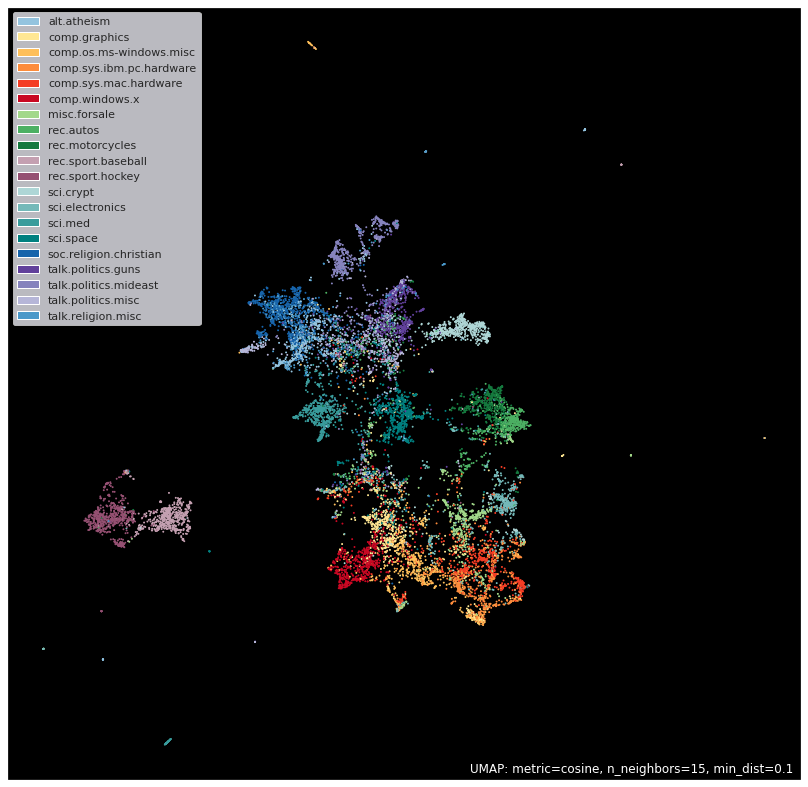

In [19]:
se_mapper = umap.UMAP(metric="cosine", random_state=42).fit(se_vectors)
umap.plot.points(
    se_mapper,
    labels=np.array([dataset['target_names'][x] for x in targets]),
    color_key=COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
)

This looks very similar to the ``WassersteinVectorizer``; perhaps with a little more messy mixing of colours in some regions. For the most part, however, this is a very good representation and significantly cheaper to compute.

## Step 3c: Combine Word and Document Vectors with ApproximateWassersteinVectorizer

Sometimes even that isn't fast enough. If we want to go really fast the best thing to do is reduce as much as possible to basic linear algebra. If we want to represent each bag-of-vectors by the (weighted) average the vectors in the bag we can do that with a simple matrix multiplication. Such averaging has a tendency to push all the representations in the same general direction (i.e. the (weighted) average of all the word vectors), but we can correct for that with a little more linear algebra. This is a very simplistic approach, but it can be very effective, and is packaged up in the ``ApproximateWassersteinVectorizer``: it operates on the same kinds of data, and has the same general goals as the ``WassersteinVectorizer``, but is a very crude approximation. The trade-off for being a very poor approximation is a guge gain is speed. And as before we have the same basic API, we need to provide the bag information, and the vectors that correspond.

In [20]:
%%time
awe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_vectors = awe_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

CPU times: user 9.94 s, sys: 5.07 s, total: 15 s
Wall time: 7.29 s


As always we will record the amount of time this took. Notably this is blindingly fast, even compared to the ``SinkhornVectorizer``, so if you have a tremendously large corpus this may be your best option.

In [21]:
approx_wass_time = %timeit -n 1 -r 1 -o awe_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)

4.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


We can also once again visualize the results with UMAP.

<AxesSubplot:>

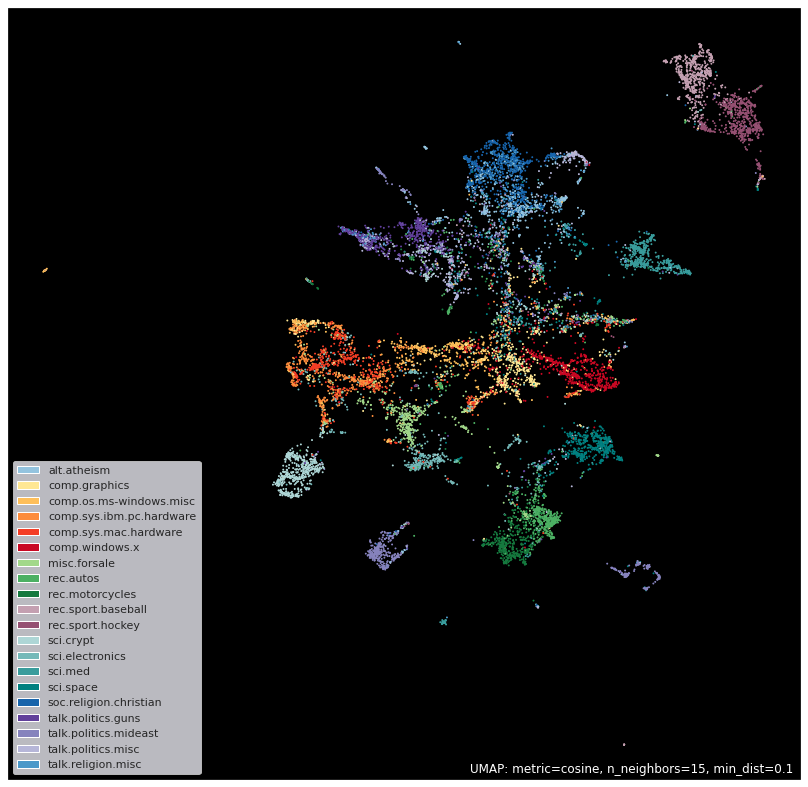

In [22]:
awe_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_vectors)
umap.plot.points(
    awe_mapper,
    labels=np.array([dataset['target_names'][x] for x in targets]),
    color_key=COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
)

The result has the same general flavour as the ``WassersteinVectorizer`` and the ``SinkhornVectorizer`` but clearly mixes things a little more -- collapsing a distribution to its centre of mass will tend to lose a lot of more subtle information that may be valuable. Still, the speed improvement may be worth the trade-off in the case of very large datasets.

## Compare the Different Document Vectors

Looking at UMAP visalizations of the resulting vectors gives us some idea of how things are performing at a broad qualitative level, but it would be useful to have a somewhat more exacting or quantitative view to compare how well the different vectorizations are performing. Fortunately, since we actually have labelled data, we can use each of the different vectorizations as input to a classifier and see how well the classifiers perform. Since, ideally, we care most about preserving nearest neighbour structure we will use a KNNClassifier from scikit-learn as a simple baseline classifier. We can make use of basic cross validation to get a basic comparison of classifier performance.

In [23]:
import sklearn.model_selection
import sklearn.neighbors

We do have the very basic representation, based on the information weighted bag-of-words. Unfortunately that is very high dimensionsal, and won't work well with a KNNClassifier. We can remedy that a little by using the ``CountFeatureCompressionTransformer`` from ``vectorizers.transformers``. This is, essentially, an SVD tuned to work well with sparse count data as measured with cosine distance. This works like any other sklearn transformer, and will given us lower dimensional vectors to work with for comparison with the fancier approaches.

In [24]:
compressor = vectorizers.transformers.CountFeatureCompressionTransformer(
    n_components=160, 
    n_iter=7, 
    random_state=42
)
basic_vectors = compressor.fit_transform(info_doc_matrix)

As always we will keep a record of the time take to perform this step.

In [25]:
compression_time = %timeit -n 1 -r 1 -o compressor.fit_transform(info_doc_matrix)

8.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now on to setting up some cross-validation comparisons of different models. First we make some simple generic functions to perform cross-validation of a model over a range of feature sets, returning the results as a dataframe.

In [26]:
def cross_validate(model, data, target, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, target, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, target, n_splits=50, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, target, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        if np.mean(cv_scores) > 0.5:
            dfs.append(feature_df)
    return pd.concat(dfs)

From there it is simply a matter of running the KNNClassifier over all the difference vectorizations we have at hand.

In [27]:
knn_accuracies = cross_validation_dataframe(
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"), 
    {
        "Basic": basic_vectors,
        "ApproxWasserstein": awe_vectors,
        "Sinkhorn": se_vectors,
        "Wasserstein": we_vectors
    },
    targets,
)

We can visualize the results using seaborn. We'll use both a swarm plot, so see the overal variation of cross validation scores over various different splits, and a point plot to highlight the central tendencies for each of the different vectorization approaches.

<AxesSubplot:xlabel='Embedding', ylabel='Accuracy'>

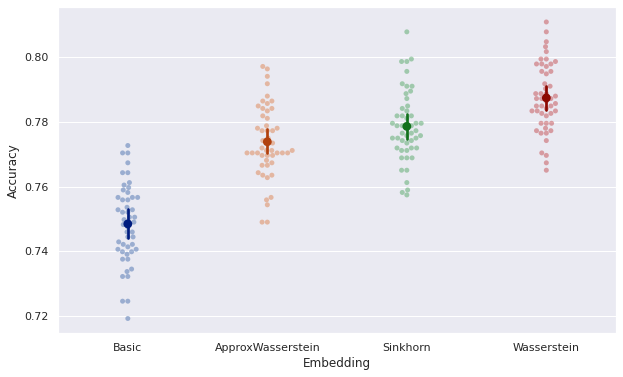

In [28]:
plt.figure(figsize=(10,6))
sns.swarmplot(
    x="Embedding", 
    y="Accuracy", 
    data=knn_accuracies, 
    alpha=0.5,
    zorder=1,
)
sns.pointplot(
    x="Embedding", 
    y="Accuracy", 
    data=knn_accuracies, 
    palette="dark",
    join=False,
    zorder=2,
    ci=99,
)

As you can see the basic approach performs surprisingly well (actually much, much better than we would get with a standard SVD of the pure bag-of-words or TF-IDF), but the various Wasserstein-style vectorizers all perform significantly better. In particular the ``WassersteinVectorizer`` is definitely the best performing vectorization at this task, although the ``SinkhornVectorizer`` and ``ApproximateWassersteinVectorizer`` are not too far behind in this case.

While those results make the ``WassersteinVectorizer`` look like the clear best choice, it is worth totalling up the time spent on the different vectorizations, as the computational costs were all quite different. We can add this all ip and put it in a dataframe along with the mean KNNClassifier accuracies to get an alternative comparison of the approaches, helping the highlight the time / quality trade-off these diffeent approaches offer. Note, that the 5.5 minutes for the word vectorization is a large chunk of the time for all the Wasserstein style vectorizations.

In [29]:
base_info_matrix_time = tokenization_time.best + doc_matrix_time.best + info_matrix_time.best
base_wass_vector_time = base_info_matrix_time + word_vector_time.best

wasserstein_vector_time = datetime.timedelta(seconds=base_wass_vector_time + wasserstein_time.best)
sinkhorn_vector_time = datetime.timedelta(seconds=base_wass_vector_time + sinkhorn_time.best)
approx_wass_vector_time = datetime.timedelta(seconds=base_wass_vector_time + approx_wass_time.best)
basic_vector_time = datetime.timedelta(seconds=base_info_matrix_time + compression_time.best)

pd.DataFrame(
    {
        "Accuracy": knn_accuracies.groupby("Embedding").Accuracy.mean().sort_values(),
        "Time": [
            humanize.precisedelta(basic_vector_time), 
            humanize.precisedelta(approx_wass_vector_time), 
            humanize.precisedelta(sinkhorn_vector_time), 
            humanize.precisedelta(wasserstein_vector_time),
        ],
    }
)

,Accuracy,Time
Embedding,,
Basic,0.748497,1 minute and 20.78 seconds
ApproxWasserstein,0.773852,8 minutes and 38.37 seconds
Sinkhorn,0.778612,11 minutes and 45.94 seconds
Wasserstein,0.787399,12 minutes and 45.04 seconds
